# [Setting Up Azure Batch AI for a Multi-Tenant Environment](https://medium.com/seismic-data-science/setting-up-azure-batch-ai-for-a-multi-tenant-environment-a51d86fb0ecb)
Orysya Stus July 2018

## In this blog, we will build out the Azure Batch AI infrastructure:
1. Upload 30 day historical weather data into blob storage for each customer. Upload model for training, supporting scripts, and package requirements into file share. [Batch Step 1]
2. Initialize Batch AI: Create the number of nodes per cluster, enable autoscaling of 0 nodes, and allow training jobs in parallel. [Batch Step 2]
3. Run Azure Batch AI jobs using Custom Toolkit. Monitor job status and examine error/output logs for each job. Upload trained model for each customer into file share. [Batch Steps 3–5]
4. Locally, predict upcoming 24 hour weather for each customer using the latest trained model downloaded from file share. [Batch Step 6]

### Pre-requisite: Setting Up the Proper Environment:
Open a command prompt and create a new conda environment. If you have never created a new conda environment check out, [this blog](https://towardsdatascience.com/environment-management-with-conda-python-2-3-b9961a8a5097).
    
    conda create -n batchai python=3.6 anaconda nb_conda_kernels

Once installations are completed, enter your environment.

    activate batchai
    
Pip install Azure specific packages needed.

    pip install azure-mgmt-batchai==2.0.0
    pip install msrest==0.4.29
    pip install azure-common==1.1.14
    pip install azure-storage==0.34.3
    
Install [fbprophet](https://facebook.github.io/prophet/docs/installation.html).

    conda install -c conda-forge fbprophet   

In [1]:
# List of customers
seismicOffices = {'sandiego': [32.9487224,-117.2397619], 'boston': [42.3511193,-71.0494583], 'newyork': [40.7572352,-73.979154],
                  'chicago': [41.8884136,-87.6376385], 'durham': [35.9955843,-78.9043578], 'sydney': [-33.8676004,151.2069574],
                  'london': [51.5181794,-0.0927338]}

## Task 1: Upload 30 day historical weather data into blob storage for each customer. Upload model for training, supporting scripts, and package requirements into file share.

### Pre-requisites:
* In portal.azure.com: Create a resource > Storage account - blob, file, table, queue > Fill out information (Note: I have created a new resource group as well).
* Register for the Dark Sky API, to receive an [API key](https://darksky.net/dev/register). Note: Your trial account allows up to 1,000 free calls per day!

### A. Upload 30 day historical weather data into blob storage for each customer. 

In [2]:
from azure.storage.blob import BlockBlobService
from azure.storage.file import FileService
from datetime import datetime, timedelta
import time
import requests
import pandas as pd
import numpy as np
import pickle
import modelfilemanager

Note: If you have issues importing BlockBlobService, [this](https://stackoverflow.com/questions/39383741/importerror-no-module-named-azure-storage-blob-when-doing-syncdb) might assist you.

In [3]:
storage_account_name = '' # Name of your Storage Account
storage_account_key = '' # Find under Storage Account > Settings > Access Keys > key1 > Key
darkskyAPIKEY = '' # Register for the Dark Sky API to gain access
dataName = 'historicalWeatherForecast' # Name of the training data set to upload into blob storage

In [4]:
def darkSkyAPI(APIKEY, latitude, longitude, priorDays):
    """ API call to Dark Sky API: Time Machine Request: https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]"""
    responseData = []
    times = timeGenerator(priorDays)
    for time in times:
        URL = 'https://api.darksky.net/forecast/{}/{},{},{}?'.format(APIKEY, latitude, longitude, time)
        r = requests.get(url = URL)
        response = r.json()
        for i in range(len(response['hourly']['data'])):
            temperature = response['hourly']['data'][i]['apparentTemperature']
            timestamp = response['hourly']['data'][i]['time']
            responseData.append({'ds': timestamp, 'y': temperature})
    responseDataframe = pd.DataFrame(responseData)   
    responseDataframe['ds'] = pd.to_datetime(responseDataframe['ds'], unit='s')
    responseDataframe = responseDataframe.to_records(index=False).tobytes() # Convert pandas dataframe to numpy recarray then convert it to a string of bytes
    return responseDataframe
    
def timeGenerator(priorDays):
    """ Creates a list of the unix time stamps which will be entered into the darkSkyAPI."""
    times = []
    for days in range(priorDays):
        nDaysAgo = datetime.now() - timedelta(days=days)
        times.append(int(nDaysAgo.timestamp()))
    return times

In [5]:
for key, value in seismicOffices.items():
    data = darkSkyAPI(APIKEY=darkskyAPIKEY, latitude=value[0], longitude=value[1], priorDays=30)
    modelfilemanager.uploadToBlobStorage(storage_account_name=storage_account_name, storage_account_key=storage_account_key, 
                        dataToUpload = data, customer = key, dataName = dataName)

historicalWeatherForecast for sandiego has been uploaded
historicalWeatherForecast for boston has been uploaded
historicalWeatherForecast for newyork has been uploaded
historicalWeatherForecast for chicago has been uploaded
historicalWeatherForecast for durham has been uploaded
historicalWeatherForecast for sydney has been uploaded
historicalWeatherForecast for london has been uploaded


### B. Upload model for training, supporting scripts, and package requirements into file share.

In [6]:
inputScriptShare = 'trainscripts' # This is the file share where all of the .py training files live
modelName = 'traintemperatureforecast' #This is the .py file which is locally stored and will be uploaded to fileshare
modelFileManager = 'modelfilemanager'

# train script location
scriptToUpload = modelName + '.py' # Local name and path of script
supportingScriptToUpload = modelFileManager + '.py' # Local name and path of supporting script
requirementsToUpload = modelName + '_requirements.txt' # Local name and path of requirements file (on this vm in this case)

In [7]:
fileService = FileService(storage_account_name, storage_account_key)
fileService.create_share(inputScriptShare, fail_on_exist=False)
print('Created file share')

# Upload train script and requirements to file share
fileService.create_file_from_path(
    inputScriptShare, None, scriptToUpload, scriptToUpload)
fileService.create_file_from_path(
    inputScriptShare, None, supportingScriptToUpload, supportingScriptToUpload)
fileService.create_file_from_path(
    inputScriptShare, None, requirementsToUpload, requirementsToUpload)
print('Uploaded scripts to file share')

Created file share
Uploaded scripts to file share


## Task 2: Initialize Batch AI: Create the number of nodes per cluster, enable autoscaling of 0 nodes, and allow training jobs in parallel.

### Pre-requisites:

Create the [service principal](https://docs.microsoft.com/en-us/cli/azure/create-an-azure-service-principal-azure-cli?view=azure-cli-latest#create-the-service-principal) using Azure CLI and set permissions.
    
    Output: 
        { 
       "appId": "APP_ID", 
       "displayName": "ServicePrincipalName", 
       "name": "http://ServicePrincipalName", 
       "password": …, 
       "tenant": "XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXX" 
        }

Create Batch AI Service Workpace.

In [8]:
# credentials used for service principal authentication
aadClientId = '' # Azure Active Directory > App registrations > Choose Application Id or appId in output from service principal
aadSecret = '' # Fill In: password in output from service principal
aadTenant = '' # Fill In: tenant in output from service principal, used in the aadTokenUri as well
aadTokenUri = 'https://login.microsoftonline.com/{}/oauth2/token'.format(aadTenant)
subscriptionId = '' # Fill in: Batch AI Workspace Subscription ID (see Overview)
adCommonUrl = 'https://login.microsoftonline.com/'
adArmUrl = 'https://management.core.windows.net/'

In [9]:
import azure.mgmt.batchai.models as models
import azure.mgmt.batchai as batchai
from azure.common.credentials import ServicePrincipalCredentials

### Create the Batch AI Client.

In [10]:
def create_batchai_client():
    creds = ServicePrincipalCredentials(client_id=aadClientId,
                                                secret=aadSecret,
                                                tenant=aadTenant,
                                                token_uri=aadTokenUri)
    
    client = batchai.BatchAIManagementClient(
        credentials=creds,
        subscription_id=subscriptionId)
    return client

client = create_batchai_client()

### Create cluster to train.

To determine ideal VM size for your application, go [here](https://docs.microsoft.com/en-us/azure/cloud-services/cloud-services-sizes-specs).

In [11]:
# VM
vmSize = 'STANDARD_D11_V2' 
clusterName = 'sampleCluster'

# specify the credentials used to remote login your GPU node
adminUserName = '' # Fill in: storage account name
adminUserPassword = '' # Fill in: password in output from service principal
relativeMountPoint = 'azurefileshare'

resourceGroup = '' # Fill in: specify the location in which to create Batch AI resources
workspace = 'samplebatchaiworkspace' # Fill in: batch ai workspace info

# Batch AI Job parameters
experimentName = 'testexperiment'

### Set the cluster parameters.

In [12]:
parameters = models.ClusterCreateParameters(
    vm_size=vmSize,
    scale_settings=models.ScaleSettings(
#         manual=models.ManualScaleSettings(target_node_count=nodes_count) # Manually scale settings, not recommended
        auto_scale = models.AutoScaleSettings(minimum_node_count=0, maximum_node_count = 5)
    ),
    user_account_settings=models.UserAccountSettings(
        admin_user_name=adminUserName,
        admin_user_password=adminUserPassword
    ),
    # Configure each node in the cluster
    node_setup=models.NodeSetup(
        # Mount shared volumes to the host
        mount_volumes=models.MountVolumes(
            azure_file_shares=[
                models.AzureFileShareReference(
                    account_name=storage_account_name,
                    credentials=models.AzureStorageCredentialsInfo(
                        account_key=storage_account_key),
                    azure_file_url='https://{0}/{1}'.format(
                        fileService.primary_endpoint, inputScriptShare),
                    relative_mount_path=relativeMountPoint)],
        ),
    ),
)

### Create and run cluster.

In [13]:
_ = client.clusters.create(resourceGroup, workspace, clusterName, parameters).result()
cluster = client.clusters.get(resourceGroup, workspace, clusterName)

### Create an experiment, if it isn't created.

In [14]:
client.experiments.create(resourceGroup, workspace, experimentName)

## Task 3: Run Azure Batch AI jobs using Custom Toolkit. Monitor job status and examine error/output logs for each job. Upload trained model for each customer into file share.

For each tenant, run a training job and output the trained models.

In [15]:
logDirectory = 'jobLogs' # This is the directory all of the error files will go per tenant per run
nodesCount = 1 # The number of VMs in the cluster to use for each job

### Start and run the jobs.

In [16]:
for customer in seismicOffices:
    jobName = '{0}_{1}_{2}'.format(customer, modelName, time.strftime('%Y%m%d-%H%M%S'))
    parameters = models.JobCreateParameters(
        
        # The cluster this job will run on
        cluster=models.ResourceId(id=cluster.id),
        
        # The number of VMs in the cluster to use
        node_count=nodesCount,
        
        # Write job's standard output and execution log to Azure File Share
        std_out_err_path_prefix='$AZ_BATCHAI_MOUNT_ROOT/{0}/{1}/{2}/{3}'.format(
            relativeMountPoint, logDirectory, customer, jobName),
        
        # Configure location of the training script
        input_directories=[models.InputDirectory(
            id='SAMPLE',
            path='$AZ_BATCHAI_MOUNT_ROOT/{0}'.format(
                relativeMountPoint))],
        
        # Container configuration
        container_settings=models.ContainerSettings(
            image_source_registry=models.ImageSourceRegistry(
                image='python:3')),
        
        # Toolkit specific settings
        job_preparation = models.JobPreparation(
            command_line = "pip install --upgrade pip; pip install -r $AZ_BATCHAI_INPUT_SAMPLE/{0}; pip install azure-storage-common --upgrade".format(requirementsToUpload)),
        custom_toolkit_settings = models.CustomToolkitSettings(
            command_line='python $AZ_BATCHAI_INPUT_SAMPLE/{0} --customer {1} --modelName {2} --storage_account_name {3} --storage_account_key {4}'.format(scriptToUpload, customer, modelName, storage_account_name, storage_account_key))
    )
    client.jobs.create(resourceGroup, workspace, experimentName, jobName, parameters).result()

## Task 4: Locally, predict upcoming 24 hour weather for a customer using the latest trained model downloaded from file share.

Wait for all jobs from Task 3 to be completed before running code below.

In [17]:
import fbprophet
import matplotlib.pyplot as plt

traintemperatureforecast_20180727-175804.pkl
Forecast for:  sandiego


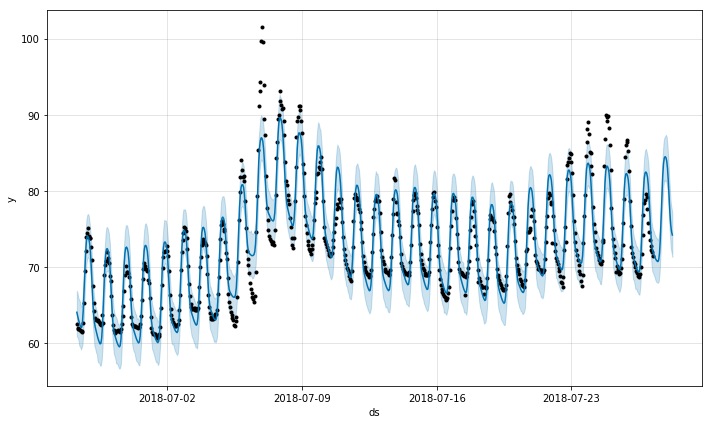

traintemperatureforecast_20180727-175803.pkl
Forecast for:  boston


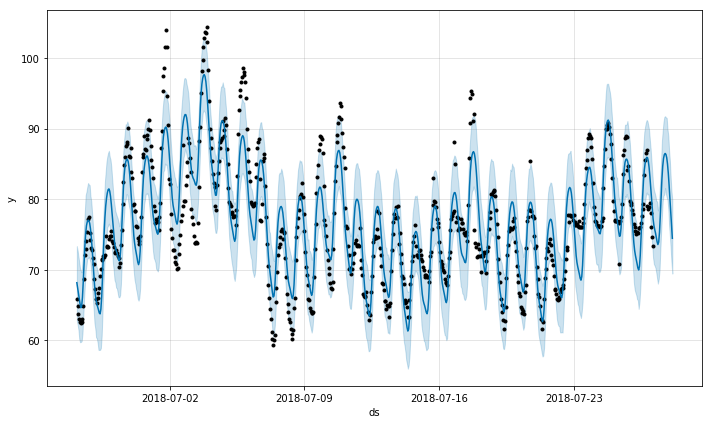

traintemperatureforecast_20180727-175734.pkl
Forecast for:  newyork


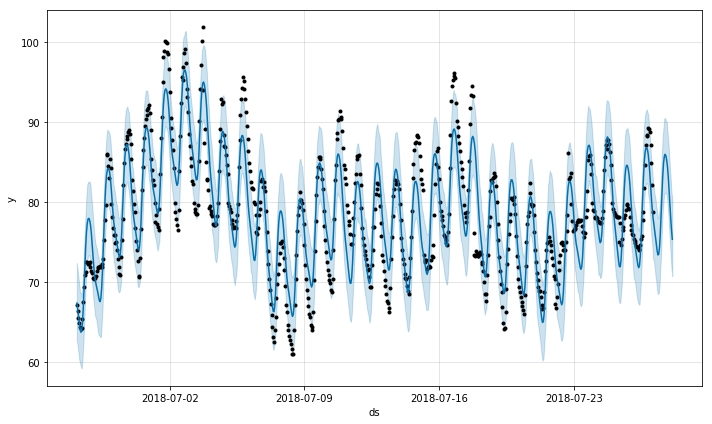

traintemperatureforecast_20180727-175935.pkl
Forecast for:  chicago


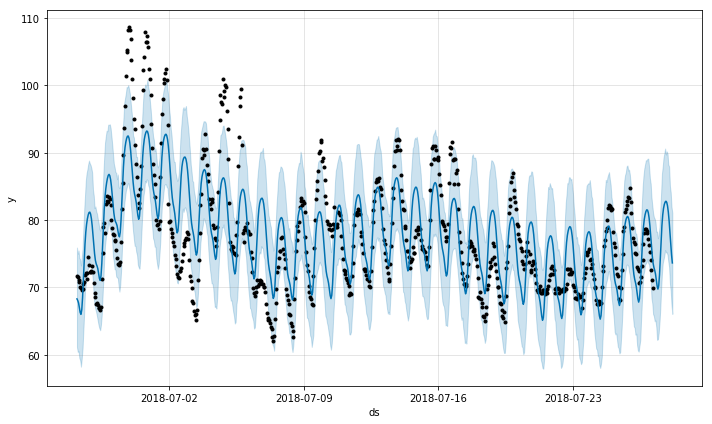

traintemperatureforecast_20180727-175733.pkl
Forecast for:  durham


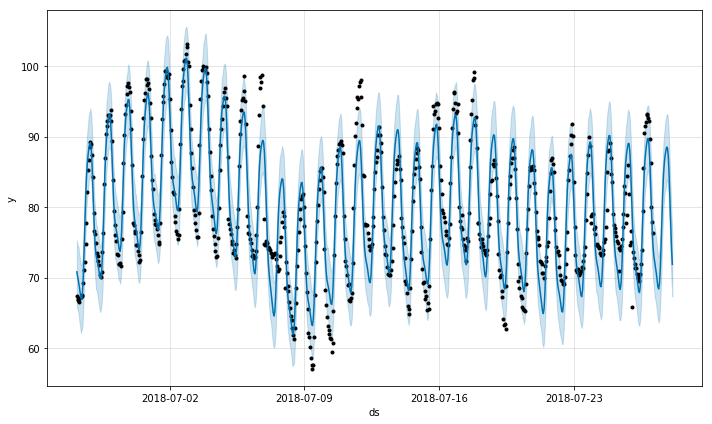

traintemperatureforecast_20180727-180447.pkl
Forecast for:  sydney


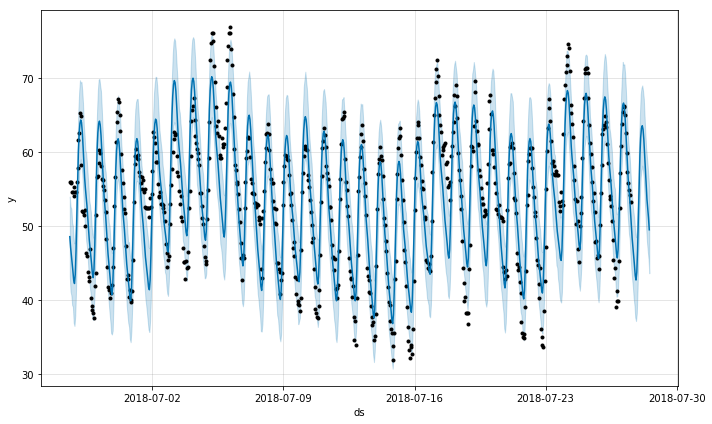

traintemperatureforecast_20180727-180538.pkl
Forecast for:  london


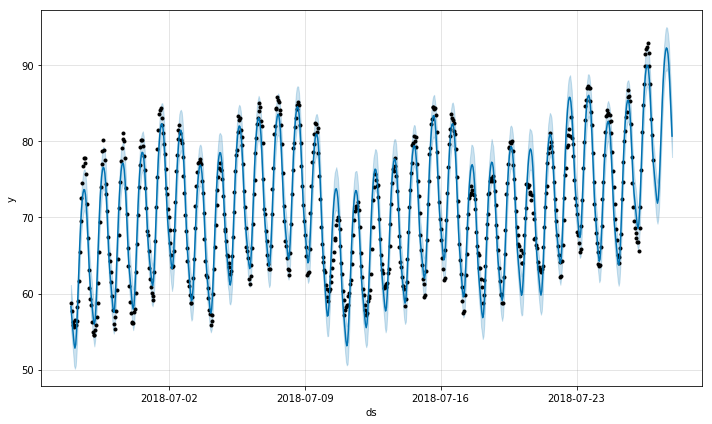

In [18]:
for customer in seismicOffices:
    trainedModel = modelfilemanager.getLatestModel(customer, modelName, storage_account_name, storage_account_key)
    future = trainedModel.make_future_dataframe(periods=24, freq='H', include_history=True)
    fcst = trainedModel.predict(future)
    print('Forecast for: ', customer)
    fig = trainedModel.plot(fcst)
    plt.show(fig)